In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go
import gmsh
import meshio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import KNeighborsClassifier

In [25]:
xSource = 50
ySource = 25
geo_file = 'rectange.geo'
isMeshRectangle =True
meshFactorForEntireSurface = 3
meshFactorForAdaptiveSurface = 2
gmsh.initialize()
gmsh.open(geo_file)
if isMeshRectangle:
    gmsh.model.mesh.field.add("Box", 1)
    gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)
    gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
    gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
    gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForAdaptiveSurface)   
    gmsh.model.mesh.field.setNumber(1, "VIn", 0.2)  
    gmsh.model.mesh.field.setNumber(1, "XMax", min(xSource + 6,100)) 
    gmsh.model.mesh.field.setNumber(1, "XMin", max(xSource - 6,0)) 
    gmsh.model.mesh.field.setNumber(1, "YMax", min(ySource + 6,50)) 
    gmsh.model.mesh.field.setNumber(1, "YMin", max(ySource - 6,0))  
    # Apply the combined field as a background mesh
    gmsh.model.mesh.field.setAsBackgroundMesh(1)
else:
    gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
gmsh.model.mesh.generate(2)
mesh_filename = 'Mesh.msh'
gmsh.write(mesh_filename)
gmsh.finalize()

In [379]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [380]:
qo = -0.001   # W/mm^2  heat which is flowing inside the block
Cp = 658 #J/kg.K
rho = 7.6e-6 #kg/mm^3
kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 0 #mm/s
Q = 0 #W/mm2

In [381]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    # if x == 0:
    #     return -qo
    # if x == 100:
    #     return qo
    # if y == 0:
    #     return -qo
    return qo

In [382]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        # gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        # gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        # Field 1: Uniform finer mesh size for surface 3
        gmsh.model.mesh.field.add("Box", 1)
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Finer mesh size
        # gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID1)
        # gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)  # Finer mesh size
        # gmsh.model.mesh.field.setNumber(1, "VIn", 0.2)  # Finer mesh size
        # gmsh.model.mesh.field.setNumber(1, "XMax", 56)  # Finer mesh size
        # gmsh.model.mesh.field.setNumber(1, "XMin", 44)  # Finer mesh size
        # gmsh.model.mesh.field.setNumber(1, "YMax", 31)  # Finer mesh size
        # gmsh.model.mesh.field.setNumber(1, "YMin", 19)  # Finer mesh size
        # Apply the combined field as a background mesh
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        # gmsh.open('rectangle_2.msh')
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            # phaseOfElement = whichPhase(T = np.mean(self.TemperatureForPhaseProperties[triNodesTags[ele]-1]))
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = kappa                          # thermal conductivity
                rho_cp = rho * Cp    # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                temp = ((dN@Jac_T_inv)[:,0]).reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            dN = np.array([-0.5,0.5]).T
            coordinates = coords[linearNodes[ele]-1].T 
            Jac_T = coordinates@dN
            if Jac_T[1]<0 or Jac_T[0]<0:
                print(Jac_T[1])
                linearNodes[ele][[0,1]] = linearNodes[ele][[1,0]]
                coordinates = coords[linearNodes[ele]-1].T 
                Jac_T = coordinates@dN
                print(Jac_T)
            for pt in range(gaussPoints):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                # print(x)
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [383]:
meshFactorForEntireSurface = 3
meshFactorForPatchSurface = 0.3
dirichiletBoundaryTemperature = 20
mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=dirichiletBoundaryTemperature,valuesPrevIteration=dirichiletBoundaryTemperature)
T_old = mesh.Temperature
T_prev_iter = mesh.Temperature
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = coords.shape[0]
nodes = np.arange(n)
interiorNodes = np.delete(nodes,dirichiletBoundary)
mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=T_old.T,valuesPrevIteration=T_prev_iter.T)
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
T_new = np.ones((n,1))*dirichiletBoundaryTemperature
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
T_new[interiorNodes] = np.linalg.inv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

-0.9999999999999964
[0. 1.]
-1.0
[0. 1.]
-0.9999999999999929
[0. 1.]
-0.9999999999999964
[0. 1.]
-1.0
[0. 1.]
-0.9999999999999929
[0. 1.]
-1.0
[0. 1.]
-0.9999999999999964
[0. 1.]
-1.0000000000000036
[0. 1.]
-1.0000000000000107
[0. 1.]
-1.0000000000000053
[0. 1.]
-1.0000000000000053
[0. 1.]
-1.0
[0. 1.]
-0.9999999999917009
[0. 1.]
-0.9999999999956284
[0. 1.]
-1.0000000000023412
[0. 1.]
-1.000000000002565
[0. 1.]
-0.9999999999955191
[0. 1.]
-0.9999999999955751
[0. 1.]
-1.0000000000026255
[0. 1.]
-1.000000000002804
[0. 1.]
-1.0000000000028102
[0. 1.]
-1.0000000000028102
[0. 1.]
-1.0000000000028104
[0. 1.]
-1.00000000000281
[0. 1.]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]
0.0
[0.98336437 0.        ]


-0.16647572875851924


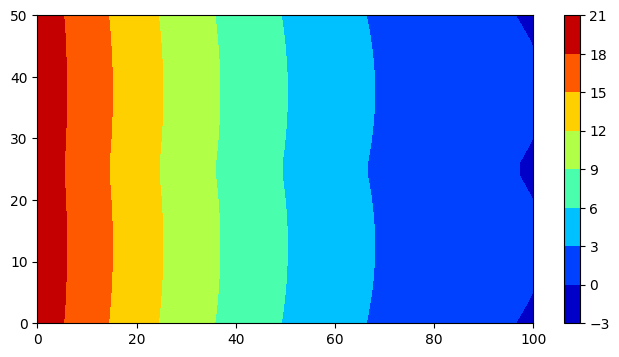

In [384]:
print(np.min(T_new))
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],T_new.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

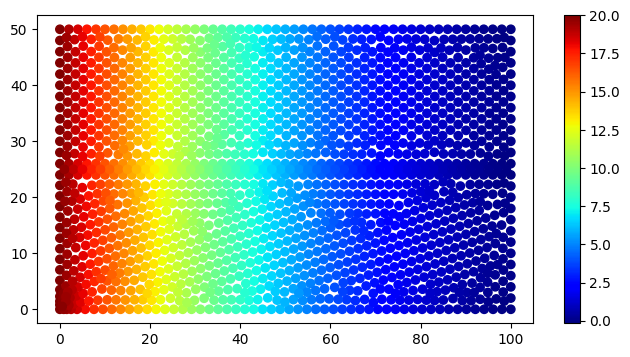

In [385]:
plt.figure(figsize=(8,4))
plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1],c=T_new.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()